# モメンタム投資

COVID-19による大幅な景気落ち込みを含む期間のモメンタム投資戦略の評価を、実際の日経255の過去データを用いて評価してみました。
日経255の株全体でポートフォリオを構成していると仮定して(!)、週ごとにロング、ショートごとのポジションをとった結果の成績を過去データを使って評価してみました。結論としては、トントンだったということになっています。

### パッケージのロード

後の方で統計評価のために、scipy.statなども使用していますが、このノートブックの大部分で使用する以下のpythonパッケージを最初にロードします。この部分は純粋なpythonプログラムパートなので読み流してください。

In [72]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os

## 市場データ
### データのロード
プロジェクトで使用するデータは、1日の終値(closing data)です。 ここでは日経255銘柄の株式を見ていきます。また、すべての期間のデータを使用するのではなく、2021/4/22時点の銘柄企業が上場している2019年1月(=ソフトバンクが2018年12月に最後に上場したので、それ以降)以降のデータを使用しています。 

In [74]:
%%time
nikkei255 = pd.read_csv('../nikkei255.csv', index_col=0)
path = os.path.join(os.environ['CSVDIR'] ,'daily')

li = []
for code, company in tqdm(nikkei255.iterrows()):
    df_each = pd.read_csv(os.path.join(path, str(code) + '.csv'), usecols=['date', 'close'])
    df_each['date'] = pd.to_datetime(df_each['date'])
    df_each = df_each.set_index('date')
    df_each = df_each.rename(columns={'close': company['name']})
    li.append(df_each)

close = pd.concat(li, axis = 1)


Wall time: 1.64 s


### データについての統計情報
今回使用するデータ`close`(終値)の統計情報を以下に示します。

In [76]:
close.describe()

,日清製粉グループ本社,明治ホールディングス,日本ハム,サッポロホールディングス,アサヒグループホールディングス,キリンホールディングス,宝ホールディングス,キッコーマン,味の素,ニチレイ,...,電通グループ,Zホールディングス,トレンドマイクロ,サイバーエージェント,楽天,リクルートホールディングス,日本郵政,東宝,セコム,コナミホールディングス
count,557.000000,557.000000,557.000000,557.00000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,...,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,1956.468582,7785.978456,4402.588869,2265.46140,4463.000000,2269.790844,1120.867145,5561.588869,1964.390485,2748.087971,...,3518.795699,453.471147,5593.799283,1262.063172,1026.317204,3805.200717,977.982258,4197.706093,9396.154122,4788.365591
std,315.949900,592.735082,376.178534,286.75597,599.242979,185.558826,198.928606,786.671991,200.896126,194.765053,...,770.819409,151.769762,509.252269,323.288713,141.705265,682.376547,191.852120,410.860121,431.257934,1017.216693
min,1503.000000,6250.000000,2927.000000,1660.00000,3088.000000,1848.500000,625.000000,3760.000000,1642.500000,2330.000000,...,1870.000000,261.000000,3830.000000,783.750000,672.000000,2351.500000,714.900000,3080.000000,7377.000000,2564.000000
25%,1693.000000,7410.000000,4230.000000,2010.00000,3829.000000,2101.500000,996.000000,5010.000000,1819.500000,2597.000000,...,3040.000000,314.000000,5210.000000,1016.562500,935.000000,3305.500000,797.475000,3980.000000,9157.000000,4207.500000
50%,1874.000000,7660.000000,4485.000000,2275.00000,4637.000000,2280.000000,1102.000000,5400.000000,1908.500000,2758.000000,...,3620.000000,423.500000,5615.000000,1113.750000,1007.000000,3692.000000,975.300000,4280.000000,9416.000000,4720.000000
75%,2162.000000,8270.000000,4680.000000,2495.00000,4912.000000,2414.000000,1258.000000,5790.000000,2100.500000,2894.000000,...,3903.750000,607.625000,5957.500000,1534.375000,1118.750000,4237.000000,1075.375000,4500.000000,9684.750000,5110.000000
max,2666.000000,9120.000000,5100.000000,2795.00000,5515.000000,2720.500000,1608.000000,7680.000000,2506.000000,3175.000000,...,5290.000000,790.000000,6830.000000,2020.000000,1545.000000,5515.000000,1358.000000,4875.000000,10470.000000,7460.000000


### 株価の例
終値から株の値動きがどのように見えるか見てみましょう。ここでは例として、Zホールディングスの株を使用します。

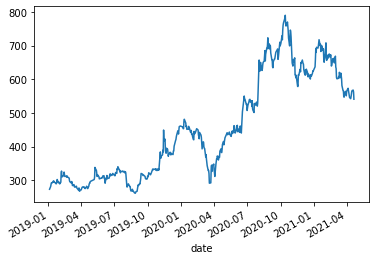

In [78]:
zholding_ticker = 'Zホールディングス'
close[zholding_ticker].plot()

## 調整済株価の週次サンプリング

取引シグナルは、毎日の価格に基づく必要はないので、適当な期間でサンプリングします。たとえば、週末の価格を使用して、週に1回取引を実行するような場合を考えます。これを行うにあたり、最初に日次調整済み終値を週次バケットにリサンプリングし、各州の最後の観測値を選択します。

pythonのpandasの`resample_prices`を使うとこれを簡単に行えます。` freq`のサンプリング頻度で `close_prices`をリサンプリングします。ここでは週次を採用するので`W`を指定します。 

In [114]:
freq = 'W'
close.resample(freq).last()

,日清製粉グループ本社,明治ホールディングス,日本ハム,サッポロホールディングス,アサヒグループホールディングス,キリンホールディングス,宝ホールディングス,キッコーマン,味の素,ニチレイ,...,電通グループ,Zホールディングス,トレンドマイクロ,サイバーエージェント,楽天,リクルートホールディングス,日本郵政,東宝,セコム,コナミホールディングス
date,,,,,,,,,,,,,,,,,,,,,
2019-01-06,2279.0,8890.0,4220.0,2301.0,4256.0,2309.0,1343.0,5850.0,1934.5,3090.0,...,4575.0,273.0,5890.0,1026.25,726.0,2581.0,1265.0,3960.0,9333.0,4750.0
2019-01-13,2257.0,8780.0,4485.0,2424.0,4359.0,2417.0,1324.0,5580.0,1916.0,3015.0,...,4895.0,292.0,5990.0,1056.25,828.0,2852.0,1321.0,4035.0,9232.0,4880.0
2019-01-20,2262.0,8610.0,4515.0,2510.0,4405.0,2500.0,1380.0,5890.0,1908.5,3010.0,...,5290.0,293.0,6410.0,1090.00,838.0,2869.0,1349.0,4135.0,9276.0,5030.0
2019-01-27,2194.0,8450.0,4600.0,2550.0,4347.0,2572.5,1313.0,5700.0,1874.0,2985.0,...,5200.0,302.0,6410.0,1071.25,855.0,2777.5,1328.0,3980.0,9167.0,5100.0
2019-02-03,2223.0,8410.0,4325.0,2475.0,4559.0,2621.0,1237.0,5730.0,1691.0,2947.0,...,5270.0,289.0,5790.0,862.50,802.0,2944.0,1324.0,3995.0,9055.0,4605.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28,1912.0,7250.0,4935.0,2333.0,4733.0,2184.5,1503.0,6630.0,2352.0,2914.0,...,3680.0,559.9,5570.0,1787.50,1332.0,5294.0,1077.5,4430.0,9519.0,6640.0
2021-04-04,1836.0,7060.0,4740.0,2275.0,4600.0,2109.5,1514.0,6770.0,2222.0,2774.0,...,3520.0,566.9,5580.0,1951.00,1315.0,5420.0,950.6,4505.0,9333.0,6740.0
2021-04-11,1829.0,6940.0,4940.0,2276.0,4757.0,2050.0,1513.0,6630.0,2220.0,2837.0,...,3525.0,545.9,5510.0,1920.00,1319.0,5223.0,930.0,4700.0,9392.0,6880.0


後の処理のため、関数定義しておきます。

In [82]:
def resample_prices(close_prices, freq='M'):
    """
    Resample close prices for each ticker at specified frequency.
    
    Parameters
    ----------
    close_prices : DataFrame
        Close prices for each ticker and date
    freq : str
        What frequency to sample at
        For valid freq choices, see http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    
    Returns
    -------
    prices_resampled : DataFrame
        Resampled prices for each ticker and date
    """

    ret = pd.DataFrame(close_prices.resample(freq).last())
    return ret

### データの可視化
`close`終値に対して適用した、上記の表だけでは把握しにくいので、グラフとして以下で可視化していきます。

In [84]:
import plotly.graph_objs as go
import plotly.offline as offline_py

color_scheme = {
    'index': '#B6B2CF',
    'etf': '#2D3ECF',
    'tracking_error': '#6F91DE',
    'df_header': 'silver',
    'df_value': 'white',
    'df_line': 'silver',
    'heatmap_colorscale': [(0, '#6F91DE'), (0.5, 'grey'), (1, 'red')],
    'background_label': '#9dbdd5',
    'low_value': '#B6B2CF',
    'high_value': '#2D3ECF',
    'y_axis_2_text_color': 'grey',
    'shadow': 'rgba(0, 0, 0, 0.75)',
    'major_line': '#2D3ECF',
    'minor_line': '#B6B2CF',
    'main_line': 'black'}

def _generate_traces(name_df_color_data):
    traces = []

    for name, df, color in name_df_color_data:
        traces.append(go.Scatter(
            name=name,
            x=df.index,
            y=df,
            mode='lines',
            line={'color': color}))

    return traces

def plot_resampled_prices(df_resampled, df, title):
    config = {'showLink': False, 'displayModeBar': False, 'showAxisRangeEntryBoxes': True}
    layout = go.Layout(title=title)

    traces = _generate_traces([
        ('Monthly Close', df_resampled, color_scheme['major_line']),
        ('Close', df, color_scheme['minor_line'])])

    offline_py.iplot({'data': traces, 'layout': layout}, config=config)

def plot_returns(returns, title):
    config = {'showLink': False, 'displayModeBar': False, 'showAxisRangeEntryBoxes': True}
    layout = go.Layout(title=title)

    traces = _generate_traces([
        ('Returns', returns, color_scheme['major_line'])])

    offline_py.iplot({'data': traces, 'layout': layout}, config=config)

def plot_shifted_returns(df_shited, df, title):
    config = {'showLink': False, 'displayModeBar': False, 'showAxisRangeEntryBoxes': True}
    layout = go.Layout(title=title)

    traces = _generate_traces([
        ('Shifted Returns', df_shited, color_scheme['major_line']),
        ('Returns', df, color_scheme['minor_line'])])
    
    offline_py.iplot({'data': traces, 'layout': layout}, config=config)

In [116]:
monthly_close = resample_prices(close, freq)
plot_resampled_prices(
    monthly_close.loc[:, zholding_ticker],
    close.loc[:, zholding_ticker],
    '{} Stock - Close Vs Weekly Close'.format(zholding_ticker))

## 対数リターン

主要なモメンタムの指標として、価格（$ P_t $）からログリターン（$ R_t $）を計算します。:

$$R_t = log_e(P_t) - log_e(P_{t-1})$$

以下の `compute_log_returns`関数を実装して、データフレーム（` resample_prices`によって返されるものなど）を受け入れ、同様のログリターンのデータフレームを生成するようにします。 Numpyの[ログ関数]（https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html）を使用して、ログのリターンを計算します。 

In [88]:
def compute_log_returns(prices):
    """
    Compute log returns for each ticker.
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """    
    ret = np.log(prices) - np.log(prices.shift(1))

    return ret

### データ可視化
`resample_prices`のデータを用いて、対数リターンを生成します。

In [117]:
monthly_close_returns = compute_log_returns(monthly_close)
#monthly_close_returns = compute_log_returns(close)
plot_returns(
    monthly_close_returns.loc[:, zholding_ticker],
    'Log Returns of {} Stock (Weekly)'.format(zholding_ticker))

## Shift Returns
`shift_returns` functionを実装し、logリターンをシフトすることで、過去、将来のリターンの時系列データ得ます。例えば、以下にパラメータ `shift_n`が2の場合の `returns`の例を示します。:

```
                           Returns
               A         B         C         D
2013-07-08     0.015     0.082     0.096     0.020     ...
2013-07-09     0.037     0.095     0.027     0.063     ...
2013-07-10     0.094     0.001     0.093     0.019     ...
2013-07-11     0.092     0.057     0.069     0.087     ...
...            ...       ...       ...       ...
```

`shift_returns` functionの出力結果は以下の通りです:
```
                        Shift Returns
               A         B         C         D
2013-07-08     NaN       NaN       NaN       NaN       ...
2013-07-09     NaN       NaN       NaN       NaN       ...
2013-07-10     0.015     0.082     0.096     0.020     ...
2013-07-11     0.037     0.095     0.027     0.063     ...
...            ...       ...       ...       ...
```
同じ `returns`データを使用して, `shit_n`が-2の場合の`shift_returns` function 出力結果が以下のようになります:
```
                        Shift Returns
               A         B         C         D
2013-07-08     0.094     0.001     0.093     0.019     ...
2013-07-09     0.092     0.057     0.069     0.087     ...
...            ...       ...       ...       ...       ...
...            ...       ...       ...       ...       ...
...            NaN       NaN       NaN       NaN       ...
...            NaN       NaN       NaN       NaN       ...
```
_Note: The "..." represents data points we're not showing._

In [92]:
def shift_returns(returns, shift_n):
    """
    Generate shifted returns
    
    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    shift_n : int
        Number of periods to move, can be positive or negative
    
    Returns
    -------
    shifted_returns : DataFrame
        Shifted returns for each ticker and date
    """
    ret = returns.shift(shift_n)
    
    return ret

### データ可視化
前月ならびに次月のリターンを可視化します。

In [94]:
prev_returns = shift_returns(monthly_close_returns, 1)
lookahead_returns = shift_returns(monthly_close_returns, -1)

plot_shifted_returns(
    prev_returns.loc[:, zholding_ticker],
    monthly_close_returns.loc[:, zholding_ticker],
    'Previous Returns of {} Stock'.format(zholding_ticker))

In [96]:
plot_shifted_returns(
    lookahead_returns.loc[:, zholding_ticker],
    monthly_close_returns.loc[:, zholding_ticker],
    'Lookahead Returns of {} Stock'.format(zholding_ticker))

## トレードシグナルの生成

トレーディングシグナルは、トレーディングアクションのシーケンス、またはトレーディングアクションを実行するために使用できる結果です。 一般的な形式は、各日付（たとえば、月末、または取引したい頻度）に「ロング」および「ショート」株式ポートフォリオを作成することです。 このシグナルは、これらの各日付でポートフォリオのバランスを取り直し、示されているようにロング（「買い」）とショート（「売り」）のポジションを入力すると解釈できます。

週ごとの観測期間ごとに、株式を_previous_リターンで最高から最低までランク付けします。 ロングポートフォリオのパフォーマンスの高い株式と、ショートポートフォリオのパフォーマンスの低い株式を選択します。 

`get_top_n`関数を実装して、各月の最高パフォーマンスの株式を取得します。 値1を割り当てて、 `prev_returns`から最高のパフォーマンスの株式を取得します。他のすべての株式については、値0を指定します。たとえば、次の` prev_returns`を使用します。 

```
                                     Previous Returns
               A         B         C         D         E         F         G
2013-07-08     0.015     0.082     0.096     0.020     0.075     0.043     0.074
2013-07-09     0.037     0.095     0.027     0.063     0.024     0.086     0.025
...            ...       ...       ...       ...       ...       ...       ...
```

`top_n`が3の場合の`get_top_n`の出力結果は以下のようになります。
```
                                     Previous Returns
               A         B         C         D         E         F         G
2013-07-08     0         1         1         0         1         0         0
2013-07-09     0         1         0         1         0         1         0
...            ...       ...       ...       ...       ...       ...       ...
```

### データ可視化
最高のパフォーマンスと最低のパフォーマンスの株式を取得したいと考えています。 最高のパフォーマンスを発揮する株を取得するには、get_top_n関数を使用します。 パフォーマンスが最も悪い株を取得するには、get_top_n関数も使用します。 ただし、prev_returnsだけでなく、-1 * prev_returnsを渡します。 負の値を掛けると、すべての正のリターンが負になり、負のリターンが正になります。 したがって、パフォーマンスが最も悪い株が返されます。 

In [98]:
def get_top_n(prev_returns, top_n):
    """
    Select the top performing stocks
    
    Parameters
    ----------
    prev_returns : DataFrame
        Previous shifted returns for each ticker and date
    top_n : int
        The number of top performing stocks to get
    
    Returns
    -------
    top_stocks : DataFrame
        Top stocks for each ticker and date marked with a 1
    """

    ret = pd.DataFrame(columns=prev_returns.columns)
    for index, row in prev_returns.iterrows():
        monthlyTopN = pd.Series(row).nlargest(top_n) # ex ['INCY' 'BBY' 'NFLX' 'PXD' 'CRM']
        topNIndex = list(monthlyTopN.index.values)  #  ex ['INCY', 'BBY', 'NFLX', 'PXD', 'CRM']
        for col in ret.columns:
            ret.loc[index, col] = col in topNIndex #if included in topNIndex, then set True
  
    return ret.astype('int64')

In [118]:
top_bottom_n = 50
df_long = get_top_n(prev_returns, top_bottom_n)
df_short = get_top_n(-1*prev_returns, top_bottom_n)
top_n = 10
print(f'{top_n} Most Longed Stocks:')
print(', '.join(df_long.sum().sort_values(ascending=False).index[:top_n].values.tolist()))
print(f'{top_n} Most Shorted Stocks:')
print(', '.join(df_short.sum().sort_values(ascending=True).index[:top_n].values.tolist()))

10 Most Longed Stocks:
アドバンテスト, エムスリー, 太陽誘電, SCREENホールディングス, 東京エレクトロン, 川崎汽船, ソフトバンクグループ, サイバーエージェント, SUMCO, ネクソン
10 Most Shorted Stocks:
三井住友フィナンシャルグループ, 双日, 伊藤忠商事, 京セラ, みずほフィナンシャルグループ, 住友商事, オムロン, 三菱UFJフィナンシャル・グループ, トヨタ自動車, 日東電工


もう少し整理して、この2年間おおむねロングポジションにあった上位10銘柄は以下の通りです。ざっくりとハイテク素材系が強かったのかな、という印象があります。

In [102]:
df_long.sum().sort_values(ascending=False)[:10]

アドバンテスト           56
エムスリー             54
太陽誘電              54
SCREENホールディングス    50
東京エレクトロン          48
川崎汽船              45
ソフトバンクグループ        44
サイバーエージェント        44
SUMCO             43
ネクソン              43
dtype: int64

この2年間おおむねショートポジションにあった上位10銘柄は以下の通りです。〇〇フィナンシャルグループや商社系が苦戦していた様子が見て取ります。

In [104]:
df_short.sum().sort_values(ascending=True)[:10]

三井住友フィナンシャルグループ       9
双日                   10
伊藤忠商事                11
京セラ                  11
みずほフィナンシャルグループ       12
住友商事                 12
オムロン                 12
三菱UFJフィナンシャル・グループ    12
トヨタ自動車               12
日東電工                 13
dtype: int64

ロングの最上位のアドバンテストと、ショートの最下位にある三井住友フィナンシャルグループをグラフで比較してみます。

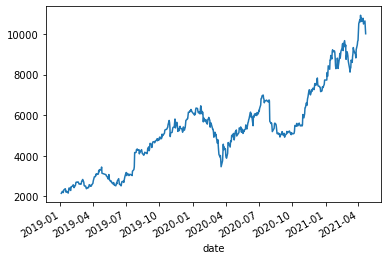

In [125]:
close['アドバンテスト'].plot()

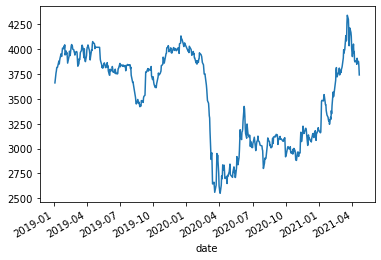

In [126]:
close['三井住友フィナンシャルグループ'].plot()

In [127]:
plot_returns(
    monthly_close_returns.loc[:, 'アドバンテスト'],
    'Log Returns of {} Stock (Weekly)'.format('アドバンテスト'))

In [128]:
plot_returns(
    monthly_close_returns.loc[:, '三井住友フィナンシャルグループ'],
    'Log Returns of {} Stock (Weekly)'.format('三井住友フィナンシャルグループ'))

## プロジェクトのリターン

トレーディングシグナルが利益を上げる可能性があるかどうかをチェックします。 

まず、このポートフォリオが返す純利益を計算します。簡単にするために、すべての株式に同じ金額の投資をすると仮定します。これにより、個々の株式のリターンの単純な算術平均としてポートフォリオのリターンを計算しやすくなります。

`portfolio_returns`関数を実装して、期待されるポートフォリオの収益を計算します。 `df_long`を使用してロングする株を示し、` df_short`を使用してショートする株を示し、 `lookahead_returns`を使用してリターンを計算します。 計算を支援するために、単一期間に投資している株式の数として「n_stocks」を提供しています。 <p>
(note: ある期間のロング・ショートする株を判断して売買した結果、を次の期間のリターンをもとに計算し、全期間を通じて得られるリターンを評価しようとしている))

In [106]:
def portfolio_returns(df_long, df_short, lookahead_returns, n_stocks):
    """
    Compute expected returns for the portfolio, assuming equal investment in each long/short stock.
    
    Parameters
    ----------
    df_long : DataFrame
        Top stocks for each ticker and date marked with a 1
    df_short : DataFrame
        Bottom stocks for each ticker and date marked with a 1
    lookahead_returns : DataFrame
        Lookahead returns for each ticker and date
    n_stocks: int
        The number number of stocks chosen for each month
    
    Returns
    -------
    portfolio_returns : DataFrame
        Expected portfolio returns for each ticker and date
    """
    ret = (df_long - df_short) * lookahead_returns/ n_stocks
    
    return ret

In [120]:
df_long - df_short

,日清製粉グループ本社,明治ホールディングス,日本ハム,サッポロホールディングス,アサヒグループホールディングス,キリンホールディングス,宝ホールディングス,キッコーマン,味の素,ニチレイ,...,電通グループ,Zホールディングス,トレンドマイクロ,サイバーエージェント,楽天,リクルートホールディングス,日本郵政,東宝,セコム,コナミホールディングス
2019-01-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-20,-1,-1,0,0,0,0,-1,-1,-1,-1,...,0,0,-1,0,1,1,0,-1,-1,0
2019-01-27,-1,-1,0,0,0,0,1,1,-1,-1,...,1,-1,1,0,0,0,0,0,-1,0
2019-02-03,-1,-1,0,0,-1,0,-1,-1,-1,0,...,-1,1,0,-1,0,-1,-1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28,0,0,-1,0,-1,0,0,-1,0,-1,...,-1,-1,0,1,1,0,1,0,-1,-1
2021-04-04,0,1,0,0,0,0,0,-1,1,1,...,-1,0,0,-1,-1,1,0,1,0,0
2021-04-11,0,0,0,0,0,0,0,1,-1,0,...,0,1,0,1,0,1,-1,1,0,1
2021-04-18,0,0,1,0,1,-1,0,-1,0,1,...,0,-1,0,0,0,-1,-1,1,0,1


In [121]:
lookahead_returns

,日清製粉グループ本社,明治ホールディングス,日本ハム,サッポロホールディングス,アサヒグループホールディングス,キリンホールディングス,宝ホールディングス,キッコーマン,味の素,ニチレイ,...,電通グループ,Zホールディングス,トレンドマイクロ,サイバーエージェント,楽天,リクルートホールディングス,日本郵政,東宝,セコム,コナミホールディングス
date,,,,,,,,,,,,,,,,,,,,,
2019-01-06,-0.009700,-0.012451,0.060903,0.052075,0.023913,0.045713,-0.014248,-0.047253,-0.009609,-0.024571,...,0.067608,0.067282,0.016835,0.028814,0.131463,0.099844,0.043317,0.018762,-0.010881,0.027001
2019-01-13,0.002213,-0.019552,0.006667,0.034864,0.010498,0.033764,0.041426,0.054067,-0.003922,-0.001660,...,0.077604,0.003419,0.067768,0.031453,0.012005,0.005943,0.020975,0.024481,0.004755,0.030275
2019-01-20,-0.030523,-0.018758,0.018651,0.015811,-0.013254,0.028587,-0.049769,-0.032790,-0.018242,-0.008340,...,-0.017160,0.030254,0.000000,-0.017352,0.020083,-0.032412,-0.015690,-0.038206,-0.011820,0.013821
2019-01-27,0.013131,-0.004745,-0.061644,-0.029853,0.047617,0.018678,-0.059626,0.005249,-0.102755,-0.012812,...,0.013372,-0.044000,-0.101727,-0.216746,-0.063993,0.058218,-0.003017,0.003762,-0.012293,-0.102098
2019-02-03,-0.007677,0.030447,-0.006961,-0.020821,0.002847,-0.024526,-0.027871,-0.095136,-0.029101,-0.095717,...,-0.068722,0.070146,-0.047754,-0.094151,-0.010025,-0.028598,-0.011394,-0.017677,-0.019516,-0.062731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28,-0.040561,-0.026556,-0.040316,-0.025175,-0.028503,-0.034936,0.007292,0.020896,-0.056858,-0.049236,...,-0.044452,0.012425,0.001794,0.087524,-0.012845,0.023522,-0.125305,0.016788,-0.019733,0.014948
2021-04-04,-0.003820,-0.017143,0.041328,0.000439,0.033561,-0.028611,-0.000661,-0.020896,-0.000900,0.022457,...,0.001419,-0.037747,-0.012624,-0.016017,0.003037,-0.037024,-0.021909,0.042375,0.006302,0.020559
2021-04-11,-0.014317,-0.004332,0.008065,-0.005286,0.002100,0.014288,-0.013307,-0.012140,-0.005194,-0.019577,...,-0.027320,0.036512,-0.025737,0.014991,0.029875,-0.021090,0.007605,0.007419,-0.018809,-0.035507


### 可視化
週次で売買を判断した場合のポートフォリオからのリターンをグラフ表示します。

In [108]:
expected_portfolio_returns = portfolio_returns(df_long, df_short, lookahead_returns, 2*top_bottom_n)
plot_returns(expected_portfolio_returns.T.sum(), 'Portfolio Returns')

## 統計検定　
### 年次のリターンに換算

In [110]:
expected_portfolio_returns_by_date = expected_portfolio_returns.T.sum().dropna()
portfolio_ret_mean = expected_portfolio_returns_by_date.mean()
portfolio_ret_ste = expected_portfolio_returns_by_date.sem()
portfolio_ret_annual_rate = (np.exp(portfolio_ret_mean * 12) - 1) * 100

print("""
Mean:                       {:.6f}
Standard Error:             {:.6f}
Annualized Rate of Return:  {:.2f}%
""".format(portfolio_ret_mean, portfolio_ret_ste, portfolio_ret_annual_rate))


Mean:                       0.000064
Standard Error:             0.000883
Annualized Rate of Return:  0.08%



年間収益率を使用すると、この戦略からの収益率を、通常は年間ベースで見積もられる他の見積収益率と比較できます。 

### t検定
帰無仮説（$ H_0 $）は、シグナルからの実際の平均リターンがゼロであるというものです。 $ H_0 $を棄却できるかどうかを確認するために、観測された平均リターンに対して1サンプルの片側t検定を実行します。<p>
(片側t検定なので、実際の帰無仮説は平均リターンが0以下？) 

最初にt統計量を計算してから、対応するp値を見つける必要があります。 p値は、帰無仮説が真である場合に観測されたものと同等またはそれ以上に極端なt統計量を観測する確率を示します。 p値が小さいということは、帰無仮説の下で観測されたt統計量を観測する可能性が低いことを意味します。したがって、帰無仮説に疑問を投げかけます。 p値を計算する前に、必要な有意水準またはアルファ（$ \ alpha $）を設定し、$ p <\ alpha $の場合はnull仮説を棄却することをお勧めします。 

このプロジェクトでは、使用する一般的な値である$ \ alpha = 0.05 $を使用します。 

`analyze_alpha`関数を実装して、ポートフォリオのリターンのサンプルに対してt検定を実行します。 t検定を実行するための `scipy.stats`モジュールをインポートしました。

Note: [`scipy.stats.ttest_1samp`](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.stats.ttest_1samp.html) performs a two-sided test, so divide the p-value by 2 to get 1-sided p-value

In [135]:
from scipy import stats

def analyze_alpha(expected_portfolio_returns_by_date):
    """
    Perform a t-test with the null hypothesis being that the expected mean return is zero.
    
    Parameters
    ----------
    expected_portfolio_returns_by_date : Pandas Series
        Expected portfolio returns for each date
    
    Returns
    -------
    t_value
        T-statistic from t-test
    p_value
        Corresponding p-value
    """
    t,p = stats.ttest_1samp(expected_portfolio_returns_by_date, .0)
    #Note: scipy.stats.ttest_1samp performs a two-sided test, so divide the p-value by 2 to get 1-sided p-value
    return t, p/2.0

In [136]:
t_value, p_value = analyze_alpha(expected_portfolio_returns_by_date)
print("""
Alpha analysis:
 t-value:        {:.3f}
 p-value:        {:.6f}
""".format(t_value, p_value))


Alpha analysis:
 t-value:        0.073
 p-value:        0.471079



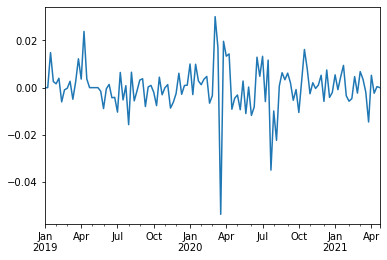

In [130]:
expected_portfolio_returns_by_date.plot()

観測された平均リターンに対する1サンプルの片側t検定の結果、次のことがわかりました。 

$p-value = 0.471079 > \alpha = 0.05$

「シグナルからの実際の平均リターンはゼロである」という帰無仮説（𝐻0）は棄却できません。平均リターンは実際にはゼロである可能性があります。 

ここでリターンはlogリターンで考えています。logリターンが0といことは、ロング、ショートに注目したトレードによりポートフォリオを中立に保てるということでしょうか。
今回の株価データにはCOVID-19による2020Q1の大幅な落ち込みも含んでいます。ここは異常値として統計的な処理として除外する処理も可能化もしれませんが、敢えて残してポートフォリオのパフォーマンスを評価してみたことになります。

